In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
import pickle

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from os import listdir
from os.path import isfile, join, isdir


import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from __future__ import print_function
import sys
import re


class ProgressBar(object):
    DEFAULT = 'Progress: %(bar)s %(percent)3d%%'
    FULL = '%(bar)s %(current)d/%(total)d (%(percent)3d%%) %(remaining)d to go'

    def __init__(self, total, width=40, fmt=DEFAULT, symbol='=',
                 output=sys.stderr):
        assert len(symbol) == 1

        self.total = total
        self.width = width
        self.symbol = symbol
        self.output = output
        self.fmt = re.sub(r'(?P<name>%\(.+?\))d',
            r'\g<name>%dd' % len(str(total)), fmt)

        self.current = 0

    def __call__(self):
        percent = self.current / float(self.total)
        size = int(self.width * percent)
        remaining = self.total - self.current
        bar = '[' + self.symbol * size + ' ' * (self.width - size) + ']'

        args = {
            'total': self.total,
            'bar': bar,
            'current': self.current,
            'percent': percent * 100,
            'remaining': remaining
        }
        print('\r' + self.fmt % args, file=self.output, end='')

    def done(self):
        self.current = self.total
        self()
        print('', file=self.output)

In [3]:
from time import sleep
import sys


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

# # # # # # # # # # # # # # # # # # # # # # # #
#  S E A R C H  W I N D O W S 
# # # # # # # # # # # # # # # # # # # # # # # #

def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size, 
                    hist_bins, 
                    #hist_range, 
                    orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel, 
                    spatial_feat=True, 
                    hist_feat=True, 
                    hog_feat=True):

    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
       
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        features = np.nan_to_num(features)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
 

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    

    #1) Define an empty list to receive features
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images       
    imgCnt = len(imgs)
    
    progress = ProgressBar(imgCnt, fmt=ProgressBar.FULL)
    i =0 
    
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image) 
            
        


        
        
        
        
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            #img_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            #img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            #img_features.append(hog_features)    
            
        if spatial_feat == True and hist_feat == True and hog_feat == True:
            features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        if spatial_feat == True and hist_feat == True and hog_feat == False:
            features.append(np.concatenate((spatial_features, hist_features)))
        if spatial_feat == True and hist_feat == False and hog_feat == True:
            features.append(np.concatenate((spatial_features, hog_features)))
        if spatial_feat == False and hist_feat == True and hog_feat == True:
            features.append(np.concatenate((hist_features, hog_features)))
        if spatial_feat == False and hist_feat == False and hog_feat == True:
            features.append( hog_features)
            
        progress.current += 1
        progress()        
    
    
    progress.done() 
        
    # Return list of feature vectors
    return features
   

In [4]:
def listAllInDir(dirName):
	#print ('checking dir: ' + dirName)
	dirListing = listdir(dirName)
	
	
	toReturn = []
	filesToProcess  = int (len(dirListing))
	for i in range(0,filesToProcess):
		
		

		valueToCheck = dirName + '/' + dirListing[i]

		if isdir(valueToCheck):						
			#print ('To Check Dir: ', valueToCheck)		
			toReturn.extend(listAllInDir(valueToCheck ))
		else:

			dirSplit = dirName.split('/')
			#print (dirSplit)
			#print 'dirName: ' , dirSplit
			if len(dirSplit) > 2:
				classFromDir = dirSplit[-1]
				
			
			fNameExt = dirListing[i].split('.')
            
			#classID = folderClass[classFromDir]()
			#print (' Directory to Check', classFromDir , classID)
			#toReturn.append([valueToCheck, classID])
			if (fNameExt[-1]=='png'):
				toReturn.append(valueToCheck)
	return toReturn		
#http://localhost:8888/notebooks/CarND-Vehicle-Detection/processImageFindCars.ipynb#

baseDir = './images/vehicles'
cars = listAllInDir(baseDir)
print ('car count :', len(cars))


baseDir = './images/non-vehicles'
notcars = listAllInDir(baseDir)
print ('car count :', len(notcars))


baseDir = './images/vehicles/HandClipped'
carsHandPicked = listAllInDir(baseDir)


baseDir = './images/non-vehicles/HandPicked'
notcarsHandPicked = listAllInDir(baseDir)

car count : 8877
car count : 9902


In [5]:
# TODO play with these values to see how your classifier
# performs under different binning scenarios
import random
from random import choice, sample

spatial = 32
histbin = 64

carsCount = len(cars)
notCarsCount = len(notcars)
reductionFactor = 1 # use bigger reduction for a smaller computer

cars    =  random.sample(cars   , int(carsCount/reductionFactor)) 
notcars =  random.sample(notcars, int(notCarsCount/reductionFactor)) 

cars    = cars    + carsHandPicked 
notcars = notcars + notcarsHandPicked 

print (len(cars))
print (len(notcars))

2621
3763


In [6]:
###################################################################################
###################################################################################
global heat

color_space       = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb


spatial_feat      = False # Spatial features on or off
spatial_size      = (16, 16) # Spatial binning dimensions


hist_feat         = True # Histogram features on or off
hist_bins         = 32    # Number of histogram bins

hog_feat          = True # HOG features on or off
hog_channel       = "ALL" # Can be 0, 1, 2, or "ALL"
orient            = 11  # HOG orientations
pix_per_cell      = 8 # HOG pixels per cell
cell_per_block    = 4 # HOG cells per block

'''
hist_feat         = False # Histogram features on or off
hist_bins         = 16    # Number of histogram bins

# 
hog_feat          = True # HOG features on or off
hog_channel       = 1 # Can be 0, 1, 2, or "ALL"
orient            = 9  # HOG orientations
pix_per_cell      = 8 # HOG pixels per cell
cell_per_block    = 4 # HOG cells per block


'''

hist_feat         = True # Histogram features on or off
hist_bins         = 32    # Number of histogram bins

hog_feat          = True # HOG features on or off
hog_channel       = "ALL" # Can be 0, 1, 2, or "ALL"
orient            = 11  # HOG orientations
pix_per_cell      = 8 # HOG pixels per cell
cell_per_block    = 2 # HOG cells per block
###################################################################################
###################################################################################

In [ ]:
print ("getting car features")
car_features = extract_features(cars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ("")
print ("getting none car features")
notcar_features = extract_features(notcars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [ ]:
# Create an array stack of feature vectors


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X = np.nan_to_num(X)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts    : ', svc.predict(X_test[0:n_predict]))
#print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print('For these {} labels:  {}'.format(n_predict, y_test[0:n_predict]))
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [7]:
fileName = "svmModelAndScaler.p"
#pickle.dump([svc,X_scaler],open(fileName,'wb'))

with open(fileName, "rb") as input_file:
    svc,X_scaler = pickle.load(input_file)


In [8]:
  
def single_img_features(img, color_space, 
                        spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True):      
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
        
  
        
        
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
def cool_heat (heatmap):
    
    tmp = heatmap.astype(float) * 0.9
    heatmap = tmp.astype(int)
    return heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        if (abs(box[0][1]-box[1][1]) > 30 and abs(box[0][0]-box[1][0]) > 30):
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold

    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


#
#  clean up the boxes to show
#  establish what boxes to show and not to show.
#

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #print ("box sizes {} {}".format(abs(bbox[0][0]-bbox[0][1]), abs(bbox[1][0]-bbox[1][1])))
        #print ("box coors {},{} - {},{}".format(bbox[0][0],bbox[0][1], bbox[1][0],bbox[1][1]))
        if (abs(bbox[0][0]-bbox[1][0])> 30 and abs(bbox[0][1]-bbox[1][1])> 50):
            cv2.rectangle(img, bbox[0], bbox[1], (0,55,255), 6)
    # Return the image
    return img

In [10]:
image = mpimg.imread('.//test_images//0703.jpg')

def init_heat():
    global heat
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

In [11]:
def createLabelsAndHeatMap(image, heat, all_hot, threshold=3):
    #heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list    
    heat_cooled = cool_heat(heat)
    heat = add_heat(heat_cooled,all_hot)  
    
    # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Apply threshold to help remove false positives    
    #    H E A T M A P     T H R E S H O L D    
    # # # # # # # # # # # # # # # # # # # # # # # # 
    
    heat = apply_threshold(heat,threshold)    
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return heatmap, labels, heat

In [12]:
def accept_box(box, imgLimit):
    toReturn = False
    if (imgLimit[0]<=box[0][0]<=imgLimit[1]  and imgLimit[0]<=box[1][0]<=imgLimit[1] and
         imgLimit[2]<=box[0][1]<=imgLimit[3] and imgLimit[2]<=box[1][1]<=imgLimit[3]):
        toReturn = True
    return toReturn

In [13]:

def combineImages(final_img, window_img, heatmap):
    imTop     = Image.fromarray(np.uint8(final_img))
    imWindow  = Image.fromarray(np.uint8(window_img))
    imHeat    = Image.fromarray(np.uint8(heatmap * 255))

  

    
    width, height = [1280,720]
    new_im = Image.new('RGB', (width,height))
    
    wpercent = (900/float(width))
    wsize = int((float(width)*float(wpercent)))
    hsize = int((float(height)*float(wpercent)))
    top_image = imTop.resize((wsize,hsize), Image.ANTIALIAS)
    
    
    
    wpercentOther = 1. - wpercent
    wsize = int((float(width)*float(wpercentOther)))
    hsize = int((float(height)*float(wpercentOther)))

    bottom_left  = imWindow.resize((wsize,hsize), Image.ANTIALIAS)
    bottom_right = imHeat.resize((wsize,hsize), Image.ANTIALIAS)


    x_offset = 0
    y_offset = 0
    new_im.paste(top_image, (x_offset,y_offset))


    y_offset = int((float(height)*float(wpercent)))
    x_offset = 0
    new_im.paste(bottom_left, (x_offset,y_offset))

    y_offset = int((float(height)*float(wpercent)))
    x_offset = int((float(width)*float(wpercentOther)))
    new_im.paste(bottom_right, (x_offset,y_offset))

    toReturn = np.array(new_im) 
    return toReturn

In [14]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [15]:
def getAllSidingWindows(image):   

    y_start_stop = [350, 800] # Min and max in y to search in slide_window
    
    winBase = 64
    winDelta  = 30
    windows = []
    for i in range(0,4):
        winH = winW = winBase + winDelta*i
        winGroup = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(winH, winW), xy_overlap=(0.7, 0.5))
        windows.extend(winGroup)
        
    return windows


In [16]:
def processImage(image):    
    
    
    
    
    
    global heat
    

    toReturn = np.copy(image)
    
    window_list = []

    window_list = getAllSidingWindows(image)
        
    filtered_list = list(filter(lambda x: accept_box(x, (0, image.shape[1], (image.shape[0]//2+50), image.shape[0]-100)), window_list))



    all_hot = search_windows(image, filtered_list, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    draw_image = np.copy(image)
    window_img = draw_boxes(draw_image, all_hot, color=(0, 0, 255), thick=6)      
    
    heat_img, labels, heat = createLabelsAndHeatMap(image, heat,all_hot, 2)  
    
    final_img       = draw_labeled_bboxes(np.copy(image), labels)       
    toReturn        = combineImages(final_img, window_img, heat_img)
    
    return toReturn


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


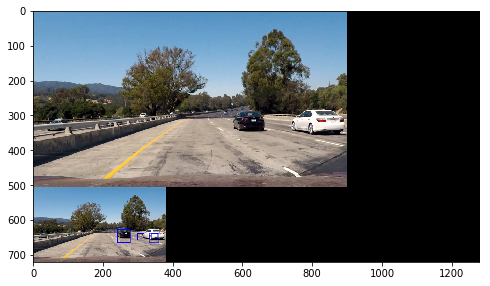

In [17]:
image = mpimg.imread('.//test_images//test1.jpg')
#plt.figure(figsize=(12,8))
#plt.imshow(image)
#draw_image = np.copy(image)
#heat = np.zeros_like(image[:,:,0]).astype(np.float)
#window_img = draw_boxes(draw_image, all_hot, color=(0, 0, 255), thick=6)                    
#heat = np.zeros_like(image[:,:,0]).astype(np.float)

init_heat()
imgToShow = processImage(image)
#print (imgToShow)
plt.figure(figsize=(8,5))
plt.imshow(imgToShow)


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
clip_input  = 'videoIn/project_video.mp4'
#clip_input  = 'videoIn/project_video_short.mp4'
clip_reader  = VideoFileClip(clip_input)

clip_output = 'videoOut/project_video.mp4'

write_clip = clip_reader.fl_image(processImage) #NOTE: this function expects color images!!
%time write_clip.write_videofile(clip_output, audio=False)


In [ ]:
#Make Short Clips for Testing

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
clip_input  = 'videoIn/project_video.mp4'
clip_short  = 'videoIn/project_video_short.mp4'
t1 = 18
t2 = 30
ffmpeg_extract_subclip(clip_input, t1, t2, targetname=clip_short)